In [1]:
pip install torch torch-geometric networkx pandas scikit-learn matplotlib numpy

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 18.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool, global_max_pool
from torch_geometric.utils import add_self_loops, degree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import wfdb
import networkx as nx
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.spatial.distance import pdist, squareform
from typing import Tuple, Optional, Dict, Any, List
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
## Graph Construction:
1. Visibility Graph: Connects time points that can "see" each other - great for capturing temporal patterns
2. Correlation Graph: For multi-channel ECG analysis based on lead correlations
3. RR-Interval Graph: Focuses on heart rate variability - most relevant for AF detection

## Further
1. Signal filtering and normalization
2. R-peak detection algorithms
3. Feature extraction from heartbeats
4. Robust handling of noisy signals

In [5]:
class AFDBPreprocessor:
    """
    Preprocessor for MIT-BIH AFDB dataset to convert ECG time series to graphs for GNN
    """
    
    def __init__(self, sampling_rate: int = 250):
        self.sampling_rate = sampling_rate
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def load_afdb_record(self, record_path: str, start_time: int = 0, 
                        duration: int = 3600) -> Dict[str, Any]:
        """
        Load AFDB record using wfdb
        
        Args:
            record_path: Path to record (without extension)
            start_time: Start time in seconds
            duration: Duration in seconds
        """
        try:
            # Read the record
            record = wfdb.rdrecord(record_path, sampfrom=start_time*self.sampling_rate, 
                                 sampto=(start_time+duration)*self.sampling_rate)
            
            # Read annotations
            annotation = wfdb.rdann(record_path, 'atr', 
                                  sampfrom=start_time*self.sampling_rate,
                                  sampto=(start_time+duration)*self.sampling_rate)
            
            return {
                'signals': record.p_signal,  # ECG signals
                'signal_names': record.sig_name,  # Signal names
                'annotations': annotation.symbol,  # Rhythm annotations
                'ann_samples': annotation.sample,  # Annotation sample positions
                'fs': record.fs  # Sampling frequency
            }
        except Exception as e:
            print(f"Error loading record: {e}")
            return None
    
    def preprocess_ecg_signal(self, signal: np.ndarray, fs: int = 250) -> np.ndarray:
        """
        Preprocess ECG signal with filtering and normalization
        """
        # Bandpass filter for ECG (0.5-40 Hz)
        nyquist = fs / 2
        low_freq = 0.5 / nyquist
        high_freq = 40.0 / nyquist
        
        b, a = butter(4, [low_freq, high_freq], btype='band')
        filtered_signal = filtfilt(b, a, signal, axis=0)
        
        # Normalize
        filtered_signal = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)
        
        return filtered_signal
    
    def detect_r_peaks(self, ecg_signal: np.ndarray, fs: int = 250) -> np.ndarray:
        """
        Detect R-peaks in ECG signal
        """
        # Simple R-peak detection
        peaks, _ = find_peaks(ecg_signal, 
                            height=np.std(ecg_signal) * 1.5,
                            distance=int(0.6 * fs))  # Minimum 0.6s between peaks
        return peaks
    
    def extract_heartbeat_features(self, ecg_signal: np.ndarray, r_peaks: np.ndarray, 
                                 fs: int = 250, window_size: int = 200) -> np.ndarray:
        """
        Extract heartbeat features around R-peaks
        """
        features = []
        half_window = window_size // 2
        
        for peak in r_peaks:
            start_idx = max(0, peak - half_window)
            end_idx = min(len(ecg_signal), peak + half_window)
            
            if end_idx - start_idx >= window_size:
                heartbeat = ecg_signal[start_idx:end_idx]
                
                # Extract features
                rr_interval = 0 if len(features) == 0 else peak - r_peaks[len(features)-1] if len(features) < len(r_peaks) else 0
                
                beat_features = [
                    np.mean(heartbeat),           # Mean amplitude
                    np.std(heartbeat),            # Standard deviation
                    np.max(heartbeat),            # Peak amplitude
                    np.min(heartbeat),            # Minimum amplitude
                    rr_interval / fs,             # RR interval in seconds
                    len(heartbeat),               # Beat duration
                    np.sum(np.abs(np.diff(heartbeat))),  # Total variation
                    np.percentile(heartbeat, 25), # 25th percentile
                    np.percentile(heartbeat, 75), # 75th percentile
                    np.trapz(heartbeat)           # Area under curve
                ]
                features.append(beat_features)
        
        return np.array(features)
    
    def create_graph_from_ecg_segment(self, ecg_data: Dict[str, Any], 
                                    segment_length: int = 5000,
                                    overlap: float = 0.5,
                                    graph_method: str = 'visibility') -> List[Data]:
        """
        Create graphs from ECG segments
        
        Args:
            ecg_data: ECG data dictionary
            segment_length: Length of each segment (samples)
            overlap: Overlap between segments (0-1)
            graph_method: Method to create graph ('visibility', 'correlation', 'rr_interval')
        """
        signals = ecg_data['signals']
        annotations = ecg_data['annotations']
        ann_samples = ecg_data['ann_samples']
        
        graphs = []
        step_size = int(segment_length * (1 - overlap))
        
        for start_idx in range(0, len(signals) - segment_length, step_size):
            end_idx = start_idx + segment_length
            
            # Extract segment
            segment = signals[start_idx:end_idx]
            
            # Get annotations for this segment
            segment_annotations = []
            for i, sample in enumerate(ann_samples):
                if start_idx <= sample < end_idx:
                    segment_annotations.append(annotations[i])
            
            # Determine segment label (majority vote)
            if segment_annotations:
                unique_annotations, counts = np.unique(segment_annotations, return_counts=True)
                segment_label = unique_annotations[np.argmax(counts)]
            else:
                segment_label = 'N'  # Normal if no annotations
            
            # Create graph based on method
            if graph_method == 'visibility':
                graph_data = self._create_visibility_graph(segment[:, 0])  # Use first channel
            elif graph_method == 'correlation':
                graph_data = self._create_correlation_graph(segment)
            elif graph_method == 'rr_interval':
                graph_data = self._create_rr_interval_graph(segment[:, 0])
            else:
                raise ValueError(f"Unknown graph method: {graph_method}")
            
            if graph_data is not None:
                # Add label
                graph_data.y = torch.tensor([self._encode_label(segment_label)], dtype=torch.long)
                graphs.append(graph_data)
        
        return graphs
    
    def _create_visibility_graph(self, signal: np.ndarray) -> Data:
        """
        Create visibility graph from time series
        """
        n = len(signal)
        edges = []
        
        # Natural visibility graph algorithm
        for i in range(n):
            for j in range(i + 1, n):
                # Check visibility between points i and j
                visible = True
                for k in range(i + 1, j):
                    # Check if point k blocks the line of sight
                    y_line = signal[i] + (signal[j] - signal[i]) * (k - i) / (j - i)
                    if signal[k] > y_line:
                        visible = False
                        break
                
                if visible:
                    edges.append([i, j])
        
        if not edges:
            return None
        
        # Create node features
        node_features = []
        for i in range(n):
            features = [
                signal[i],                    # Signal value
                i / n,                        # Normalized time position
                np.std(signal[max(0, i-10):min(n, i+10)]),  # Local standard deviation
            ]
            node_features.append(features)
        
        x = torch.FloatTensor(node_features)
        edge_index = torch.LongTensor(edges).t().contiguous()
        
        # Make undirected
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
        
        return Data(x=x, edge_index=edge_index)
    
    def _create_correlation_graph(self, signals: np.ndarray, threshold: float = 0.7) -> Data:
        """
        Create correlation graph from multi-channel ECG
        """
        if signals.shape[1] < 2:
            return None
        
        # Compute correlation matrix between channels
        corr_matrix = np.corrcoef(signals.T)
        
        # Create edges based on correlation threshold
        edges = []
        for i in range(len(corr_matrix)):
            for j in range(i + 1, len(corr_matrix)):
                if abs(corr_matrix[i, j]) > threshold:
                    edges.append([i, j])
        
        if not edges:
            return None
        
        # Node features (channel statistics)
        node_features = []
        for i in range(signals.shape[1]):
            channel_signal = signals[:, i]
            features = [
                np.mean(channel_signal),
                np.std(channel_signal),
                np.max(channel_signal),
                np.min(channel_signal),
                np.percentile(channel_signal, 25),
                np.percentile(channel_signal, 75),
            ]
            node_features.append(features)
        
        x = torch.FloatTensor(node_features)
        edge_index = torch.LongTensor(edges).t().contiguous()
        
        # Make undirected
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
        
        return Data(x=x, edge_index=edge_index)
    
    def _create_rr_interval_graph(self, signal: np.ndarray) -> Data:
        """
        Create graph based on RR intervals
        """
        # Detect R-peaks
        r_peaks = self.detect_r_peaks(signal)
        
        if len(r_peaks) < 3:
            return None
        
        # Calculate RR intervals
        rr_intervals = np.diff(r_peaks)
        
        # Create node features (each node represents an RR interval)
        node_features = []
        for i, rr in enumerate(rr_intervals):
            features = [
                rr / self.sampling_rate,      # RR interval in seconds
                signal[r_peaks[i]],           # R-peak amplitude
                signal[r_peaks[i+1]],         # Next R-peak amplitude
            ]
            
            # Add neighboring RR intervals if available
            if i > 0:
                features.append(rr_intervals[i-1] / self.sampling_rate)
            else:
                features.append(0)
            
            if i < len(rr_intervals) - 1:
                features.append(rr_intervals[i+1] / self.sampling_rate)
            else:
                features.append(0)
            
            node_features.append(features)
        
        # Create edges based on RR interval similarity
        edges = []
        threshold = 0.1  # 100ms threshold
        
        for i in range(len(rr_intervals)):
            for j in range(i + 1, len(rr_intervals)):
                if abs(rr_intervals[i] - rr_intervals[j]) / self.sampling_rate < threshold:
                    edges.append([i, j])
        
        # Also connect consecutive RR intervals
        for i in range(len(rr_intervals) - 1):
            edges.append([i, i + 1])
        
        if not edges:
            return None
        
        x = torch.FloatTensor(node_features)
        edge_index = torch.LongTensor(edges).t().contiguous()
        
        # Make undirected
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
        
        return Data(x=x, edge_index=edge_index)
    
    def _encode_label(self, annotation: str) -> int:
        """
        Encode rhythm annotations to numeric labels
        """
        label_mapping = {
            'N': 0,      # Normal
            '(AFIB': 1,  # Atrial Fibrillation
            '(AFL': 2,   # Atrial Flutter
            '(J': 3,     # AV Junctional
            '(AB': 4,    # Atrial Bigeminy
            '(SVTA': 5,  # Supraventricular Tachyarrhythmia
            '(B': 6,     # Ventricular Bigeminy
            '(T': 7,     # Ventricular Trigeminy
            '(VT': 8,    # Ventricular Tachycardia
            '(IVR': 9,   # Idioventricular Rhythm
        }
        return label_mapping.get(annotation, 0)  # Default to Normal

1. Loops through each record in your AFDB list.

2. For each record:

    A. Loops through every 1-hour chunk (up to 10 hours).

    B. Loads the ECG and annotation data.

    C. Preprocesses the ECG signal (filter + normalize).

    D. Converts the cleaned signal to graphs using rr_interval method.

3. Collects all graphs in a list (all_graphs) and returns them.

In [10]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

def process_afdb_dataset(data_dir: str, records: List[str], visualize: bool = True):
    """Process multiple AFDB records with ECG preprocessing and show outputs"""
    all_graphs = []
    
    for record in records:
        record_path = f"{data_dir}/{record}"
        
        for start_time in range(0, 36000, 3600):  # Every hour for 10 hours
            try:
                ecg_data = preprocessor.load_afdb_record(
                    record_path, start_time=start_time, duration=3600
                )
                
                if ecg_data is not None:
                    raw_signal = ecg_data['signals'][:, 0]  # First channel
                    
                    # Plot raw ECG signal (first 1000 samples)
                    if visualize:
                        plt.figure(figsize=(12, 3))
                        plt.plot(raw_signal[:1000])
                        plt.title(f"Raw ECG Signal - Record {record}, Start {start_time}s")
                        plt.xlabel("Sample")
                        plt.ylabel("Amplitude")
                        plt.show()
                    
                    # Preprocess ECG signals
                    preprocessed_signals = preprocessor.preprocess_ecg_signal(
                        ecg_data['signals'], fs=ecg_data['fs']
                    )
                    ecg_data['signals'] = preprocessed_signals
                    
                    # Plot preprocessed ECG signal
                    if visualize:
                        plt.figure(figsize=(12, 3))
                        plt.plot(preprocessed_signals[:1000, 0])
                        plt.title(f"Preprocessed ECG Signal - Record {record}, Start {start_time}s")
                        plt.xlabel("Sample")
                        plt.ylabel("Amplitude")
                        plt.show()
                    
                    # Create graphs from signal
                    graphs = preprocessor.create_graph_from_ecg_segment(
                        ecg_data,
                        segment_length=1250,
                        graph_method='rr_interval'
                    )
                    
                    for g in graphs:
                        if g is not None:
                            all_graphs.append(g)
                            # Print info
                            print(f"Graph created: Nodes={g.x.size(0)}, Edges={g.edge_index.size(1)}, Label={g.y.item()}")
                            
                            # Visualize first graph only
                            if visualize and len(all_graphs) == 1:
                                print("Node features (first 5):")
                                print(g.x[:5])
                                print("Label:", g.y.item())
                                
                                # Convert to networkx graph for visualization
                                G = to_networkx(g, to_undirected=True)
                                plt.figure(figsize=(6, 6))
                                nx.draw(G, node_size=50)
                                plt.title("Sample Graph Structure")
                                plt.show()
                
                print(f"Done: {record} at {start_time}s")
            
            except Exception as e:
                print(f"Error processing {record} at {start_time}s: {e}")
                continue
    
    print(f"\nTotal graphs created: {len(all_graphs)}")
    return all_graphs


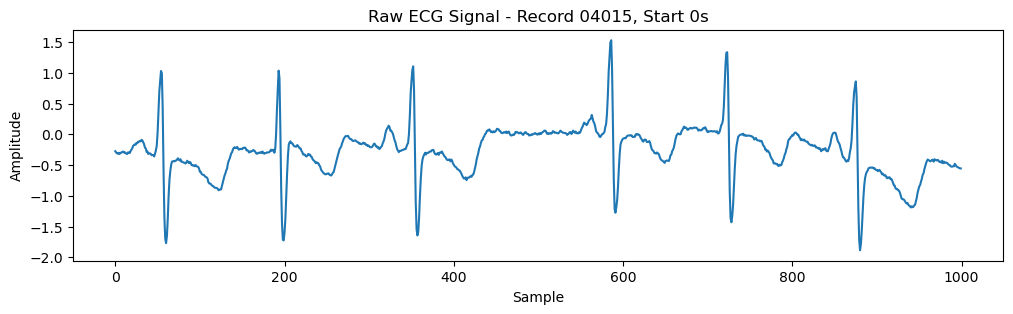

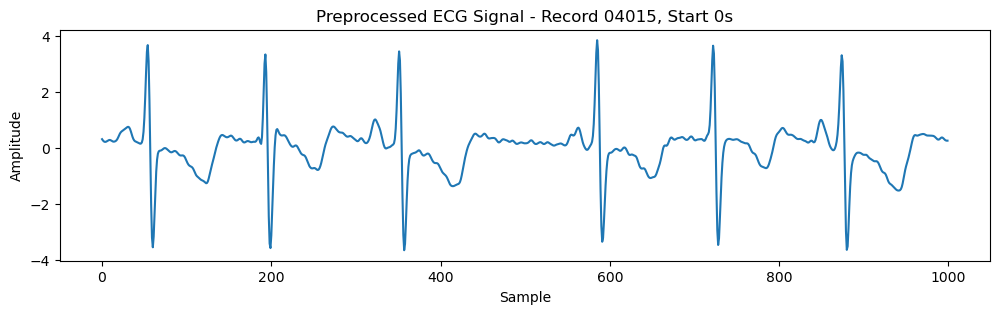

Graph created: Nodes=4, Edges=10, Label=0
Node features (first 5):
tensor([[1.1880, 3.6626, 3.4382, 0.0000, 0.9360],
        [0.9360, 3.4382, 3.8375, 1.1880, 1.1560],
        [1.1560, 3.8375, 3.3003, 0.9360, 0.9560],
        [0.9560, 3.3003, 3.6743, 1.1560, 0.0000]])
Label: 0


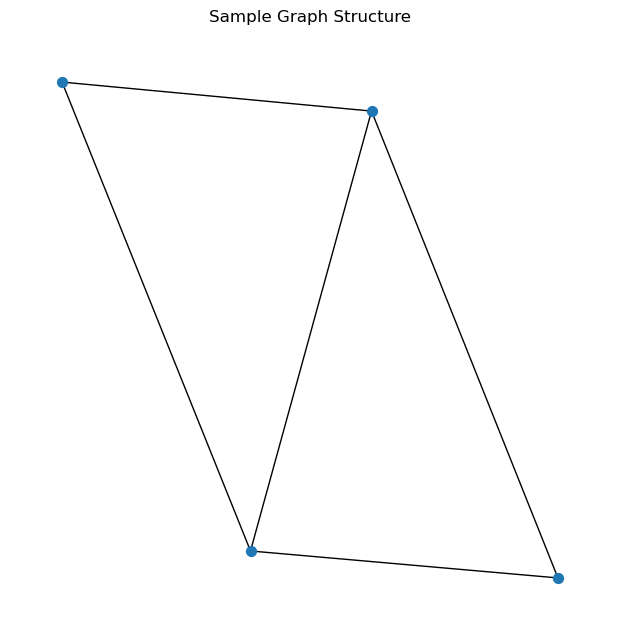

Graph created: Nodes=5, Edges=12, Label=0
Graph created: Nodes=6, Edges=26, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=5, Edges=14, Label=0
Graph created: Nodes=5, Edges=12, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=18, Label=

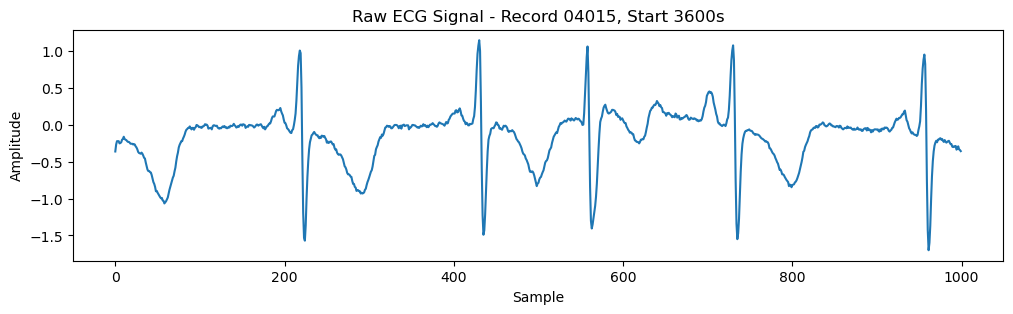

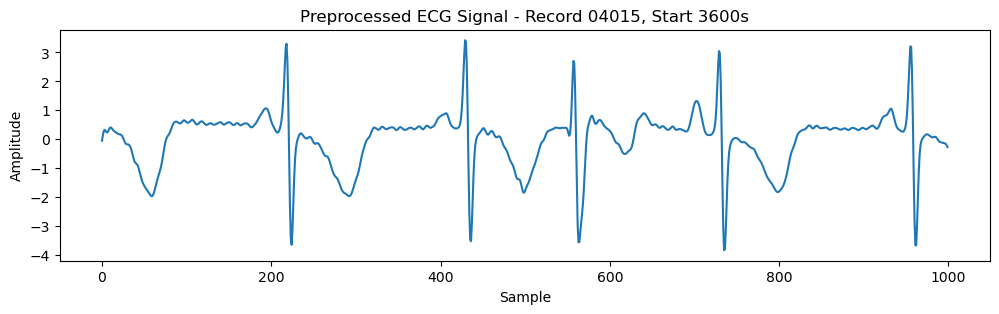

Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=5, Edges=12, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=6, Edges=28, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=5, Edges=22, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=6, Edges=40, Label=

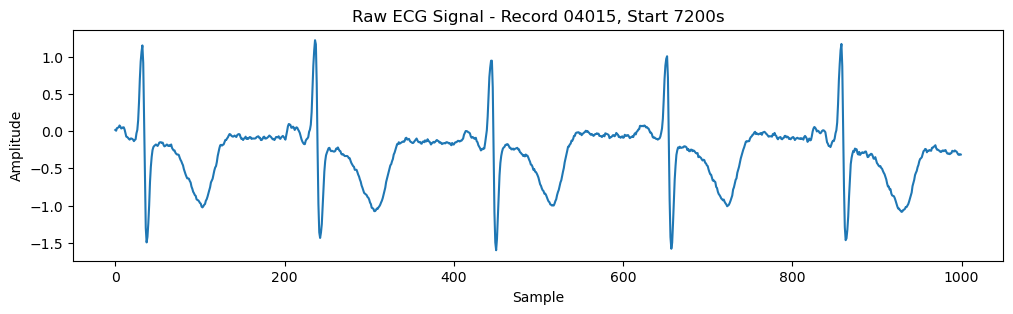

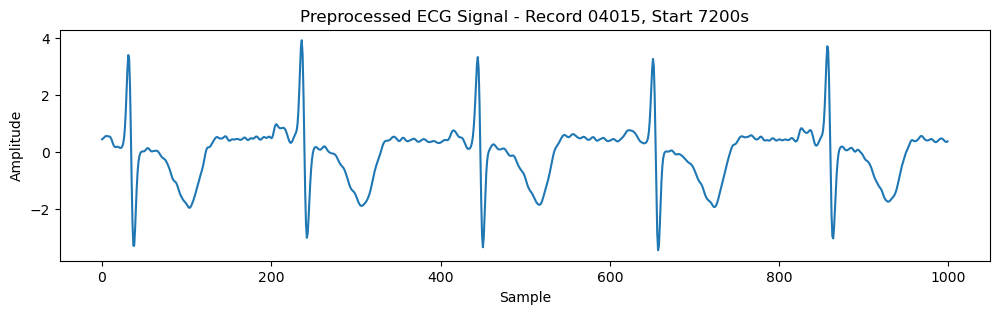

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, 

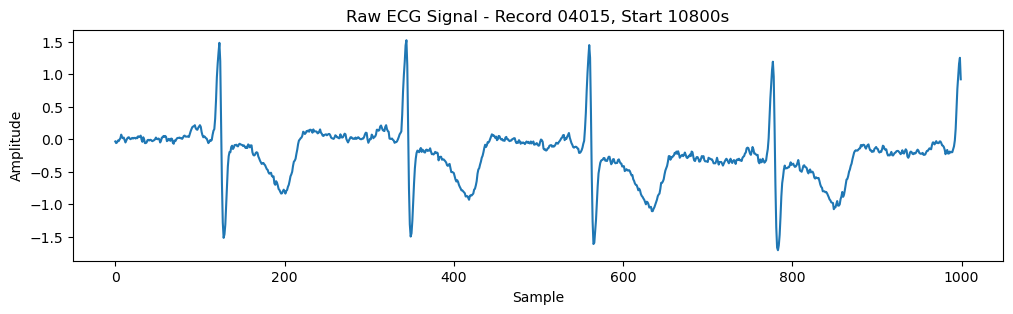

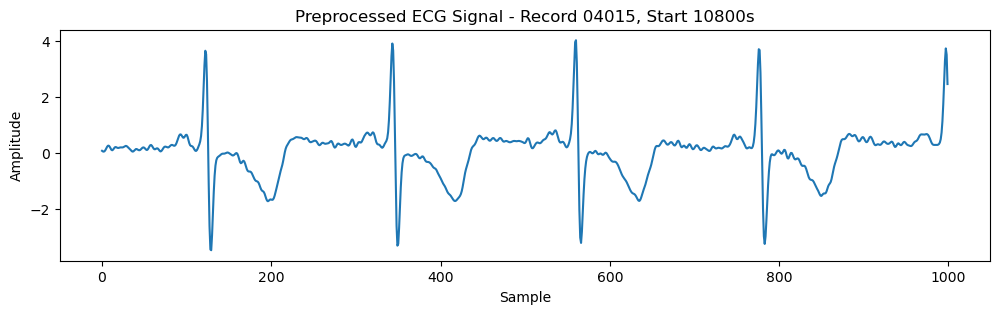

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, 

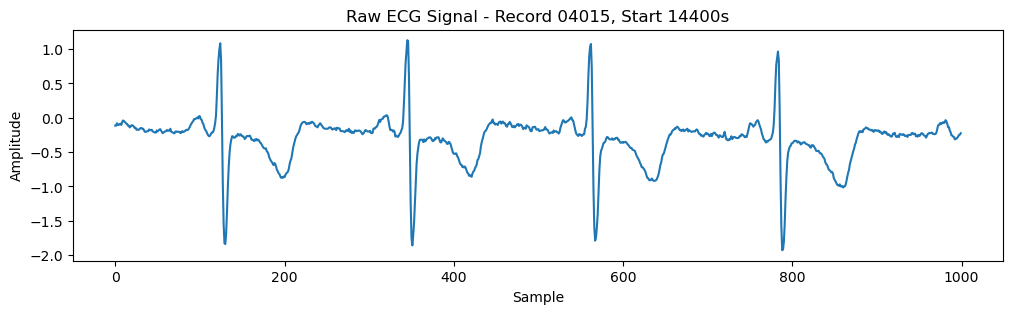

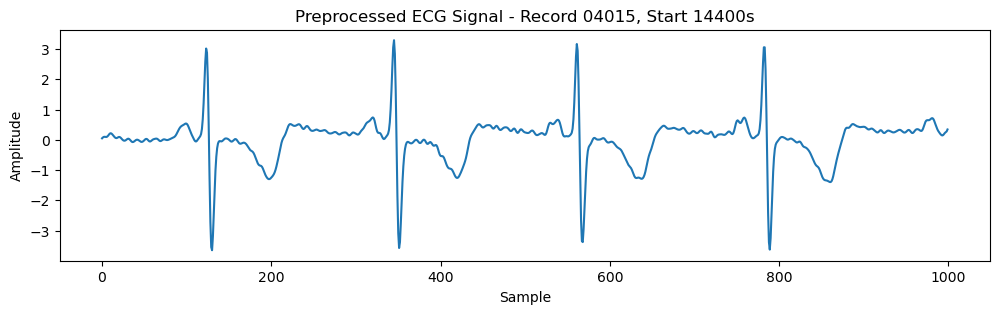

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, 

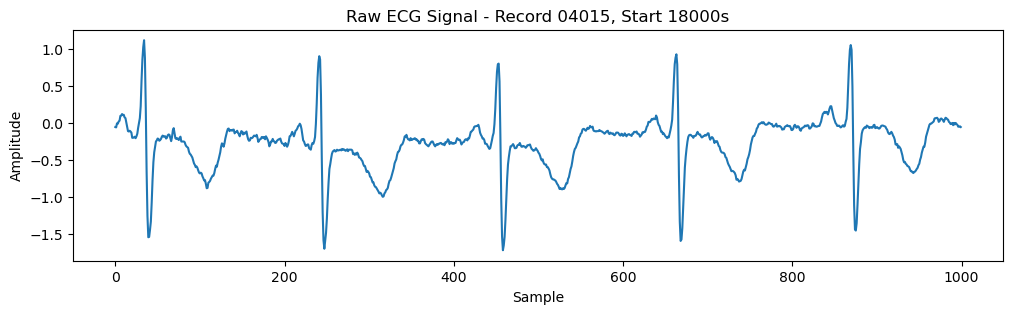

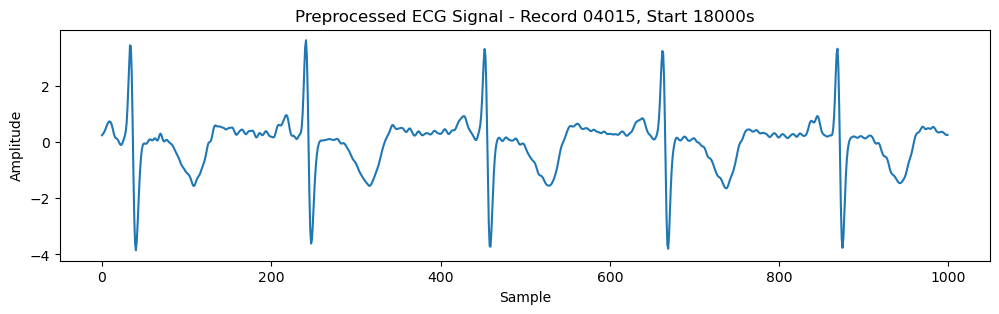

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, 

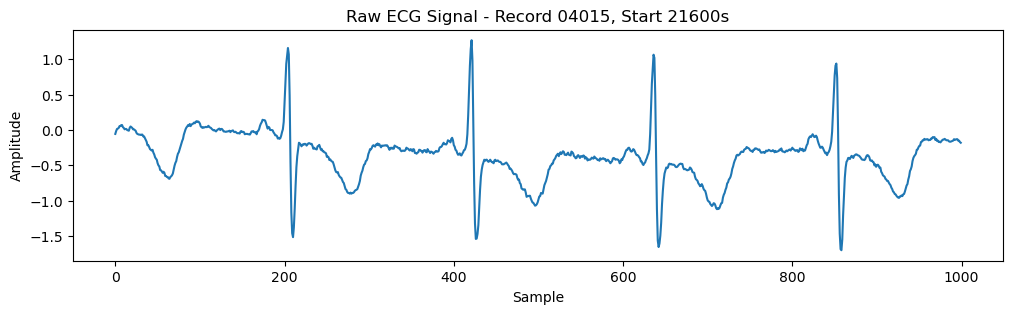

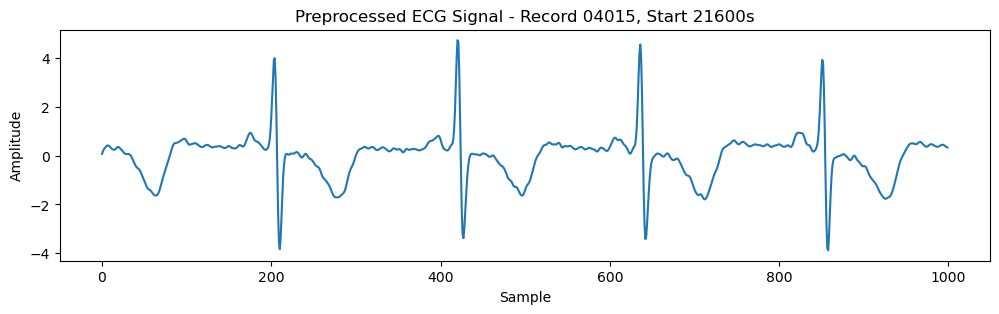

Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, 

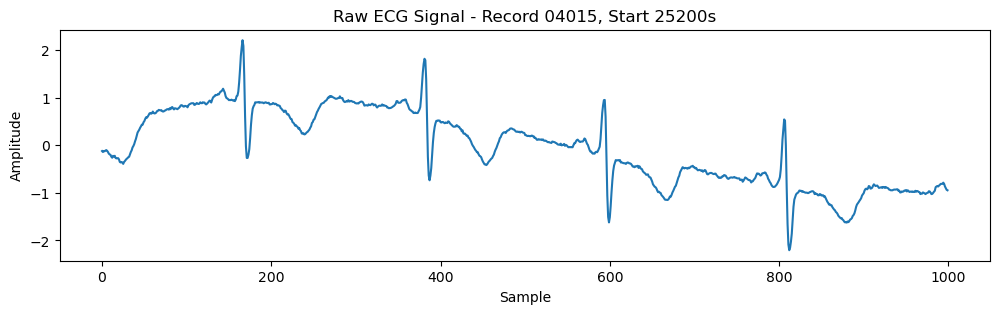

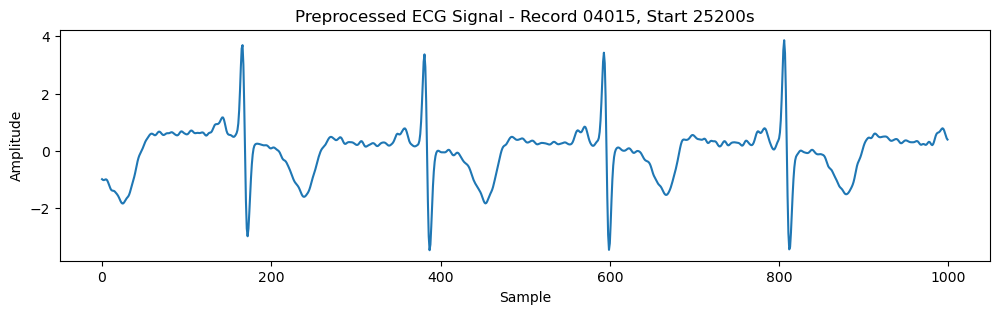

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, 

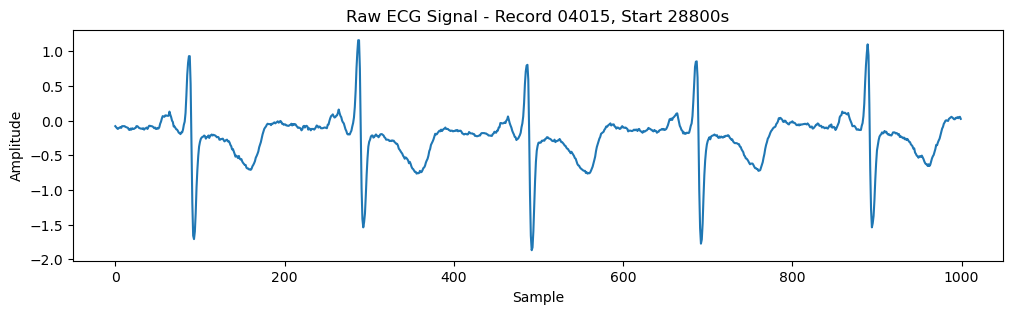

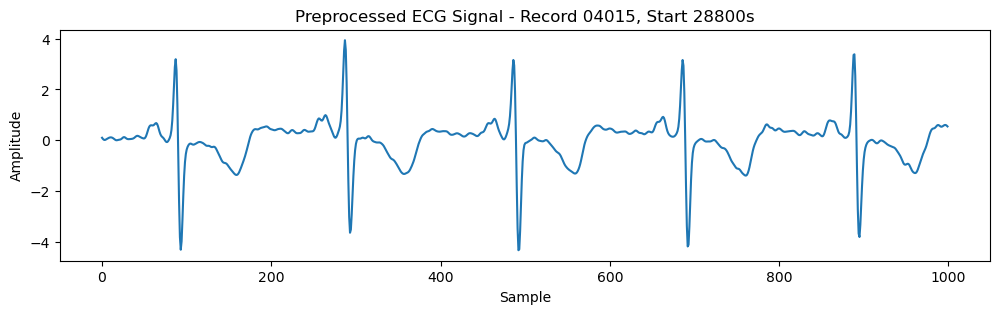

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, 

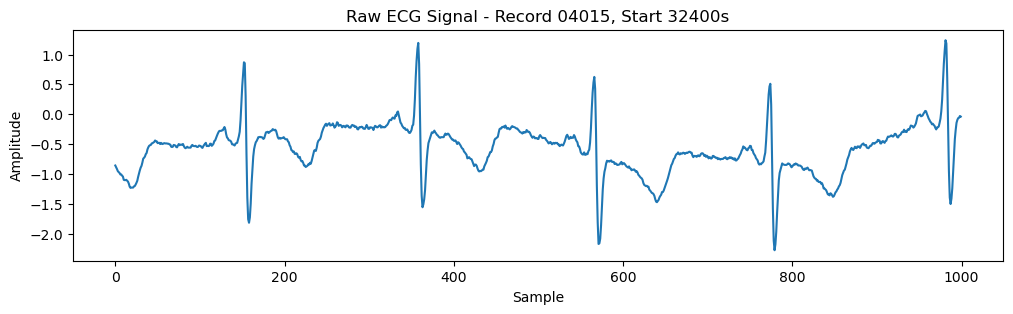

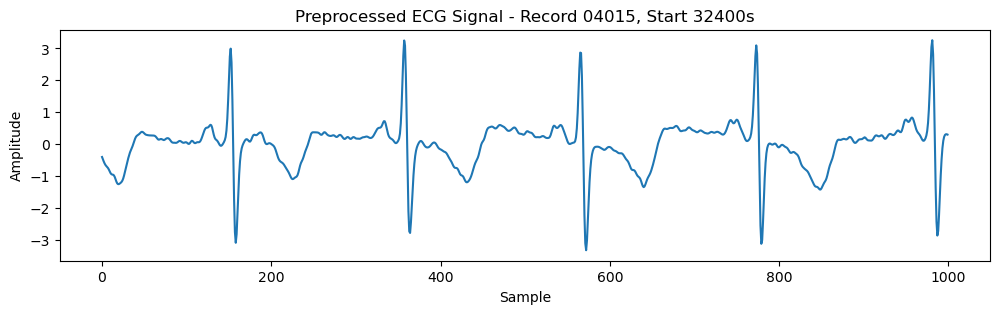

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, 

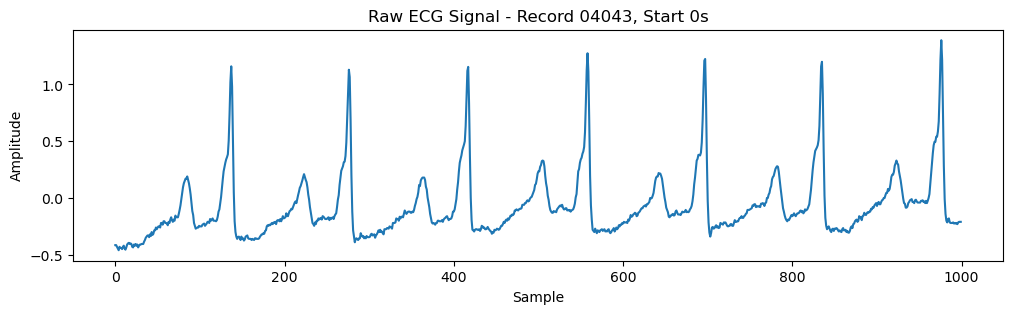

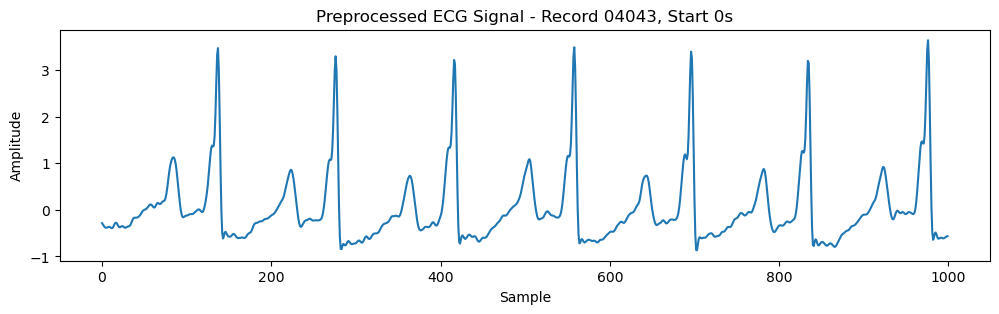

Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=2, Edges=4, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=5, Edges=16, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=2, Edges=4, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph creat

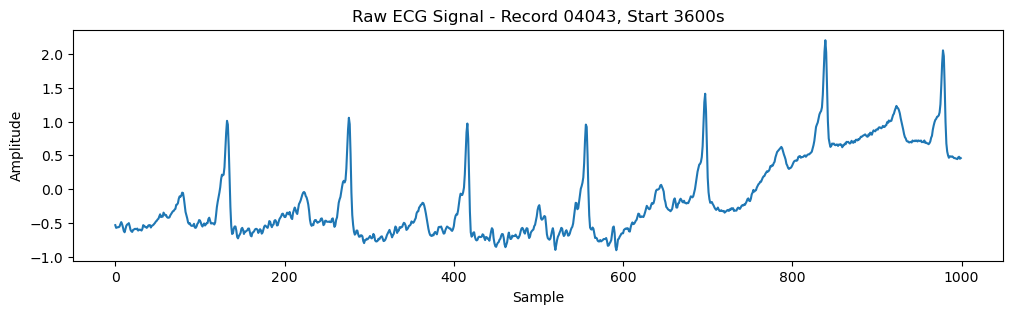

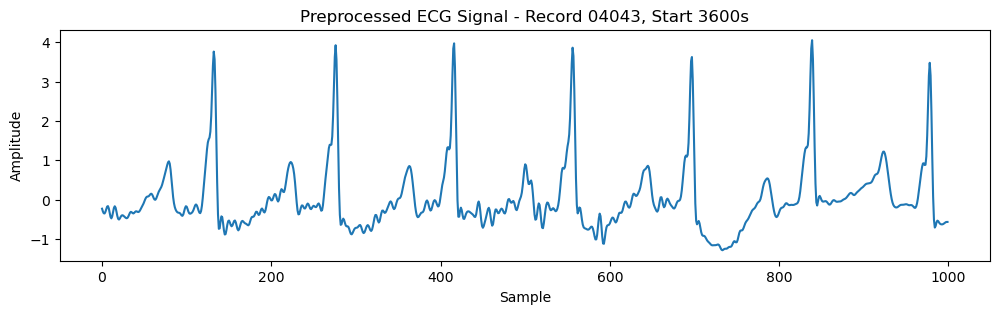

Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=2, Edges=4, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=2, Edges=4, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Gra

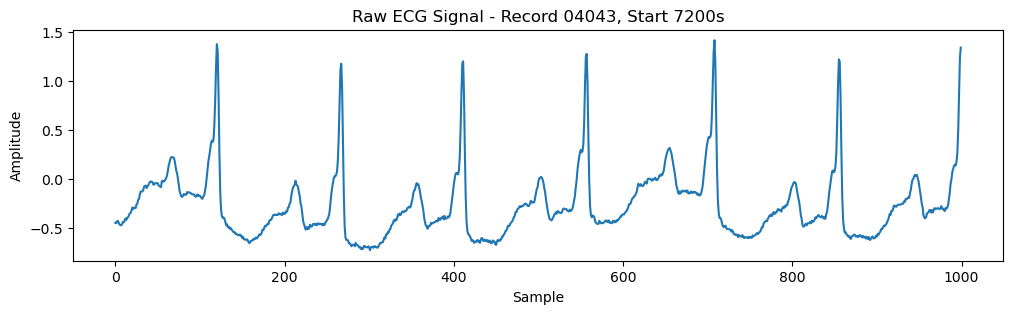

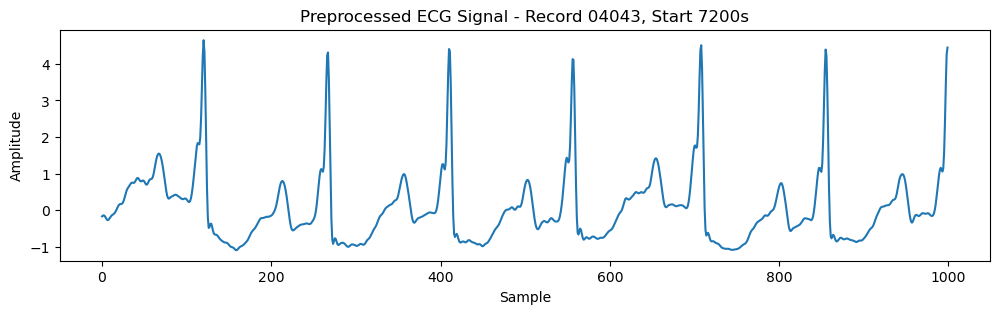

Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=5, Edges=16, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=5, Edges=16, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=12, Label

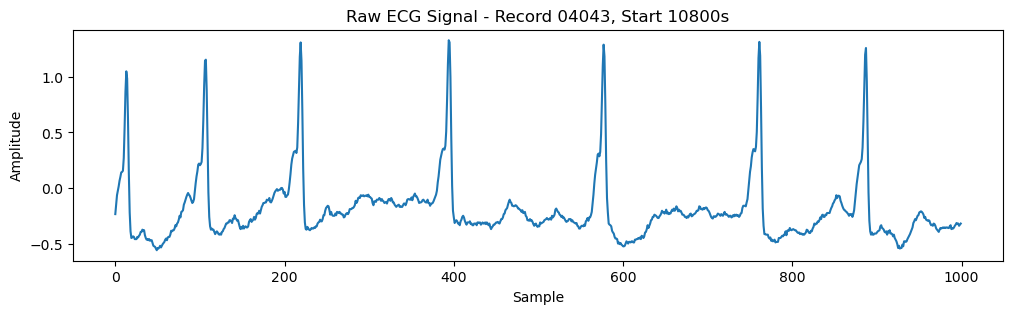

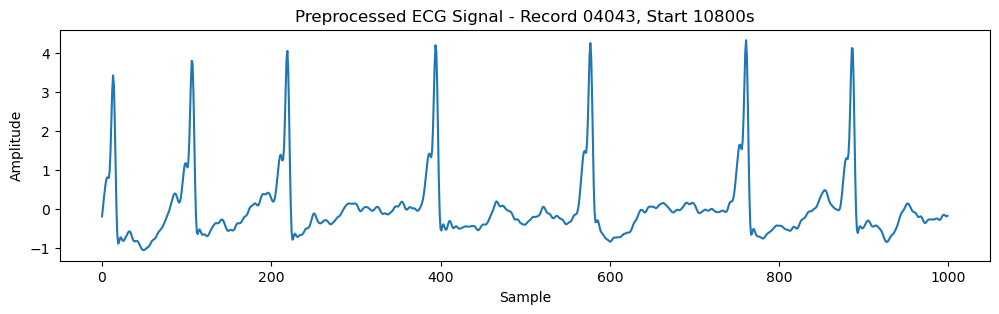

Graph created: Nodes=5, Edges=18, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=6, Edges=20, Label=0
Graph created: Nodes=5, Edges=14, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=5, Edges=14, Label=0
Graph created: Nodes=5, Edges=12, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=5, Edges=10, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=5, Edges=14, Label=0
Graph created: Nodes=5, Edges=12, Label=0
G

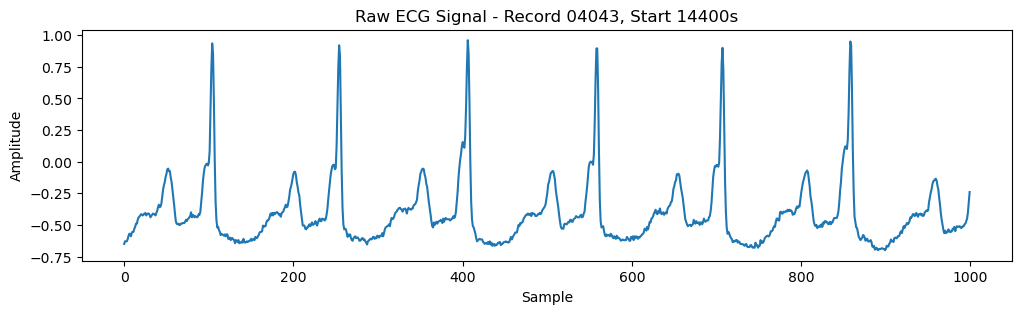

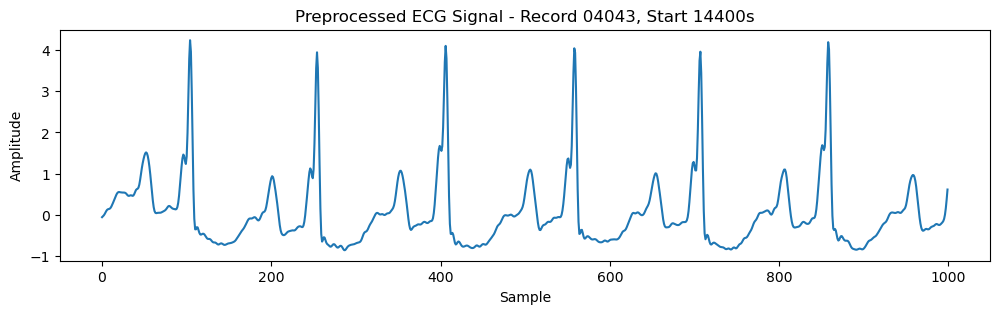

Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=5, Edges=16, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=5, Edges=16, Label=0
Graph created: Nodes=5, Edges=16, Label=0
Graph created: Nodes=5, Edges=16, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=6, Edges=22, Label=0
Graph created: Nodes=5, Edges=10, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=4, Edges=16, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=3, Edges=4, Label=0


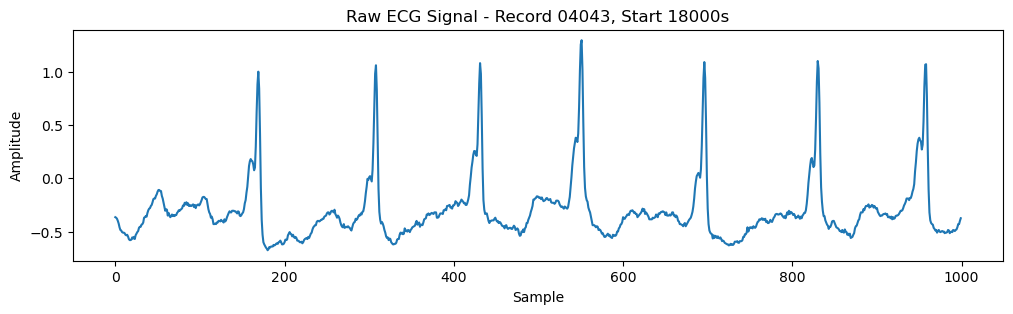

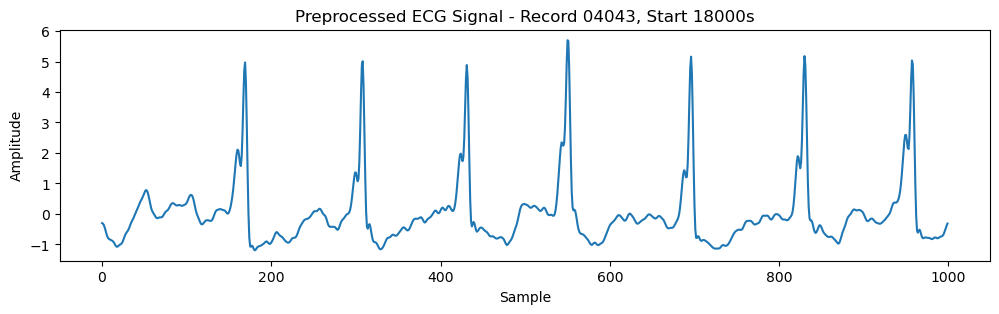

Graph created: Nodes=3, Edges=8, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=5, Edges=10, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=5, Edges=16, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0


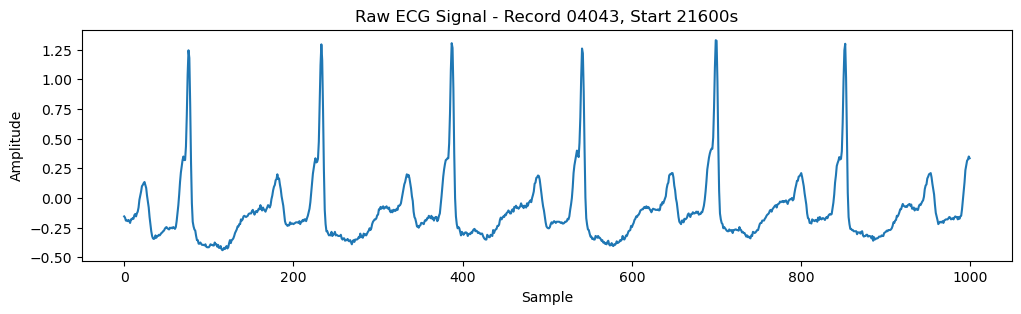

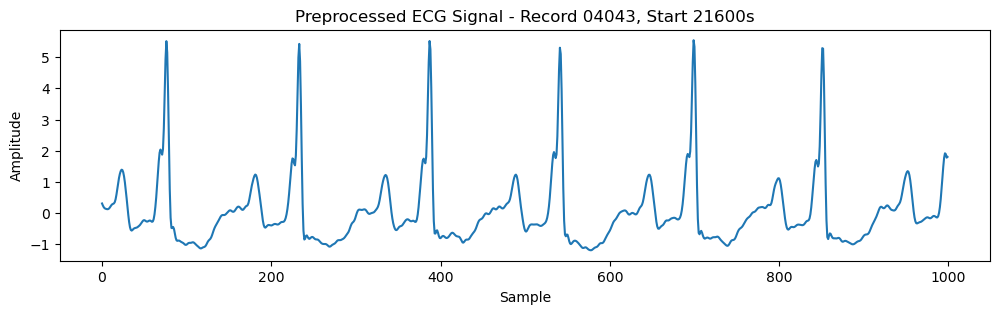

Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=5, Edges=14, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=3, Edges=6, Label

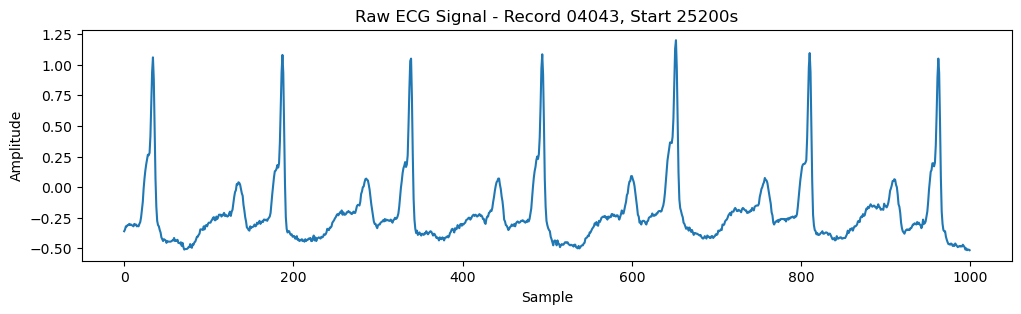

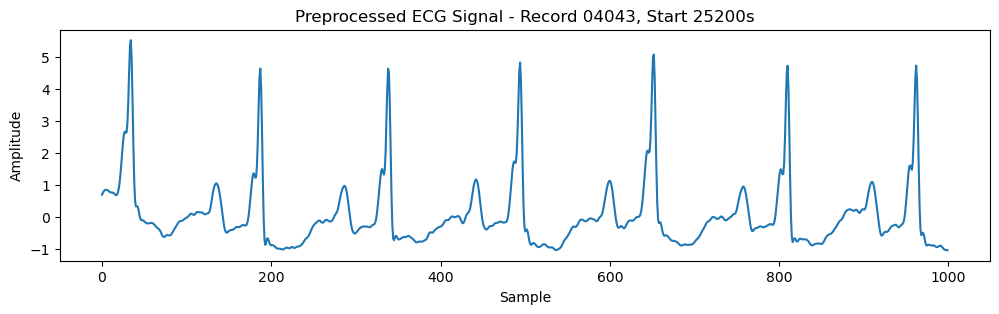

Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=42, Label=0
Graph created: Nodes=6, Edges=24, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=32, Label=0
Graph created: Nodes=5, Edges=10, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label

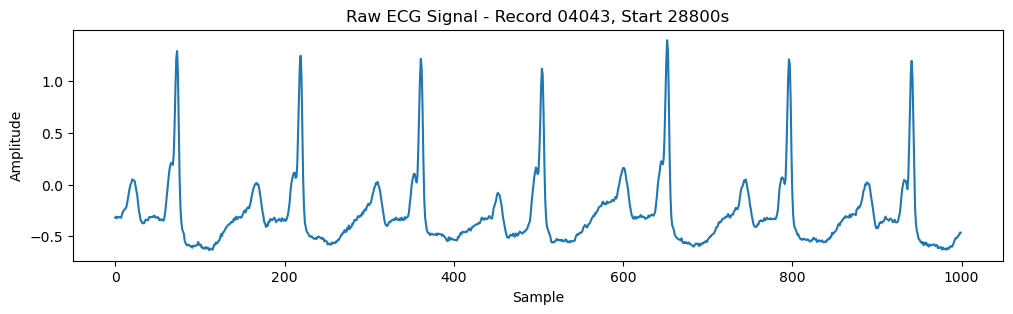

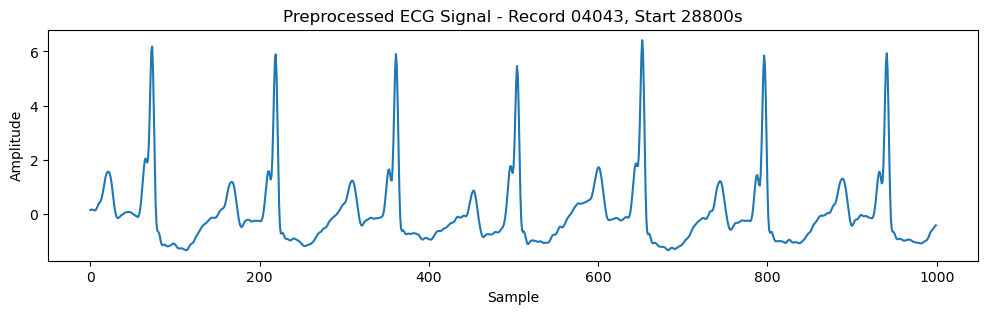

Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=5, Edges=10, Label=0
Graph created: Nodes=5, Edges=12, Label=0
Graph created: Nodes=5, Edges=12, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph created: Nodes=3, Edges=4, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=5, Edges=14, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=5, Edges=12, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph created: Nodes=5, Edges=14, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph created: Nodes=4, Edges=10, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph created: Nodes=4, Edges=6, Label=0
Graph

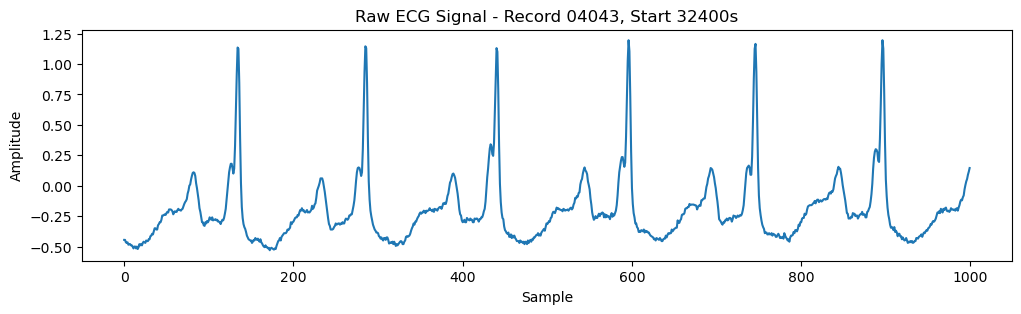

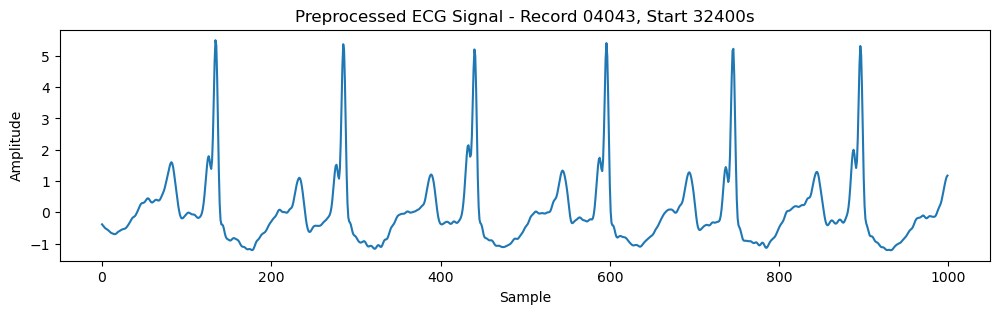

Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=7, Edges=42, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=5, Edges=16, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=7, Edges=42, Label=0
Graph created: Nodes=6, Edges=30, 

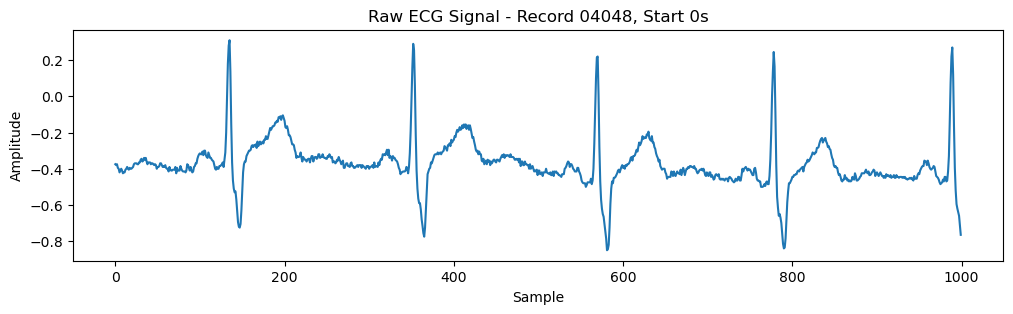

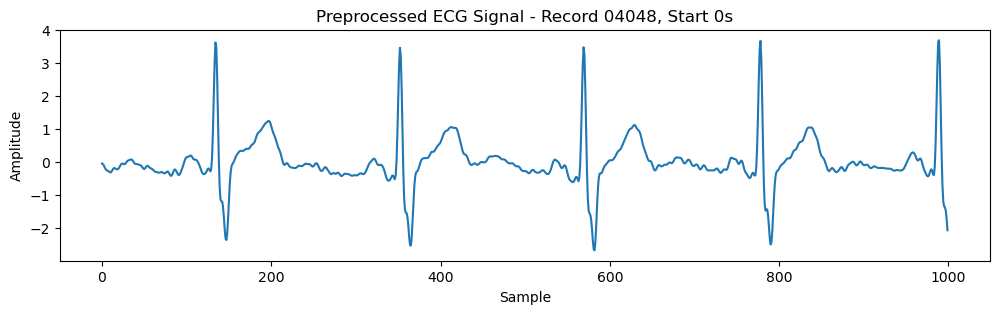

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, 

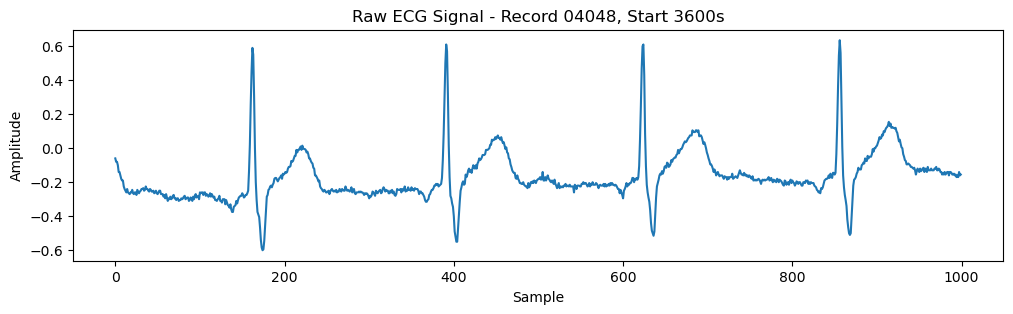

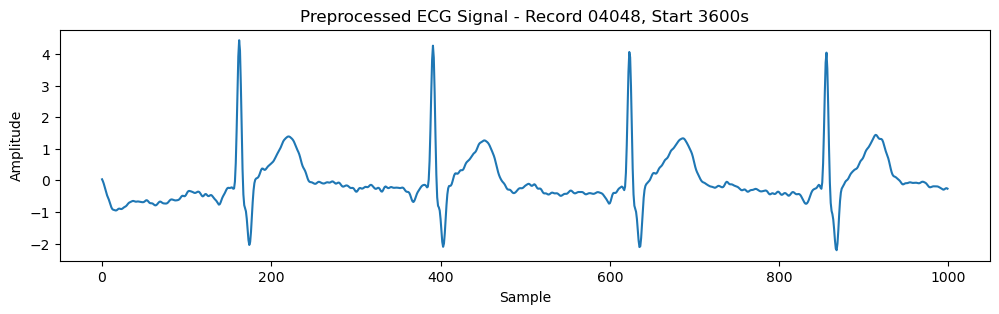

Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, 

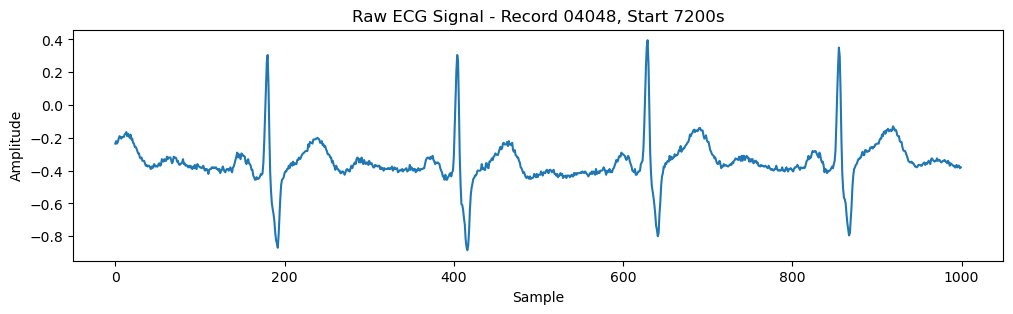

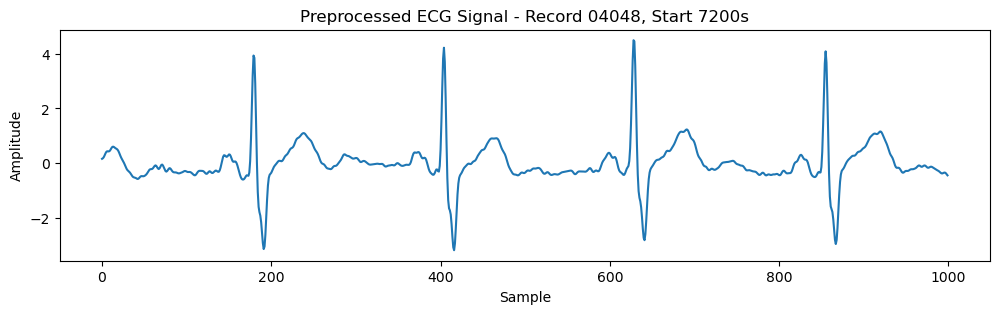

Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=6, Edges=30, Label=0
Graph created: Nodes=5, Edges=28, 

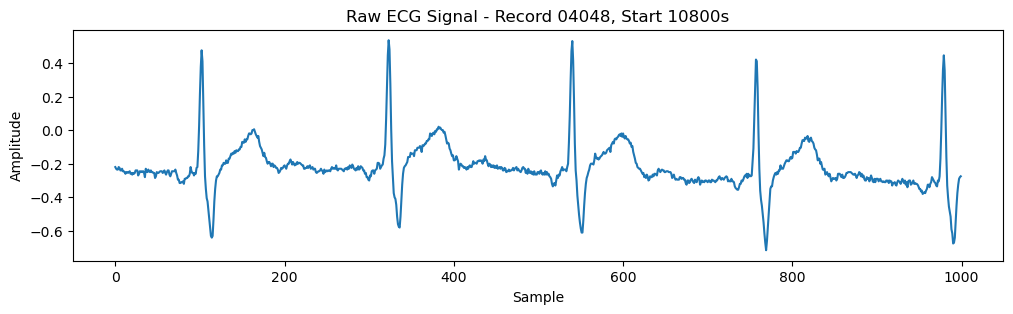

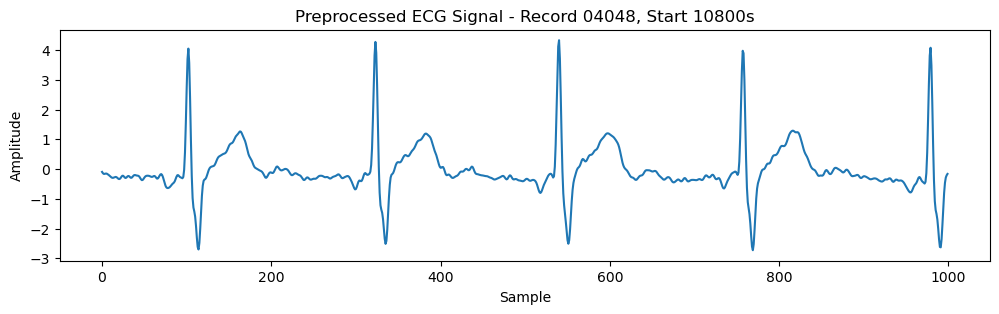

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, 

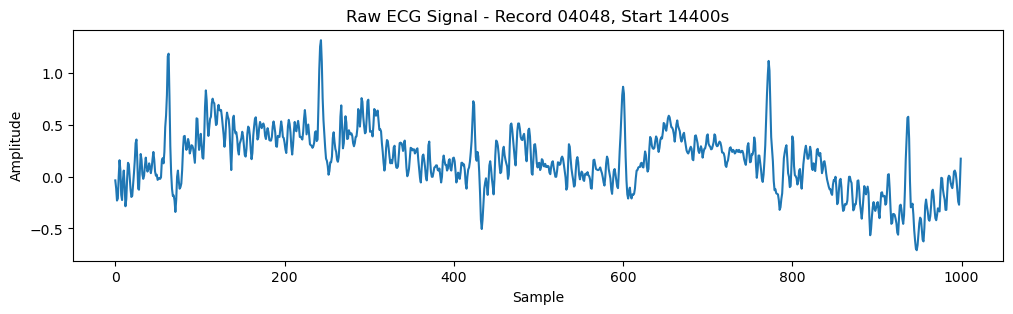

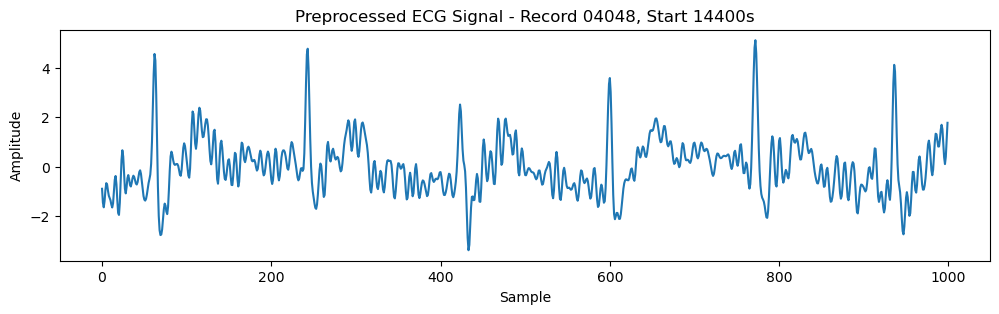

Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=7, Edges=54, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=5, Edges=14, Label=0
Graph created: Nodes=6, Edges=22, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, Label=0
Graph created: Nodes=6, Edges=40, 

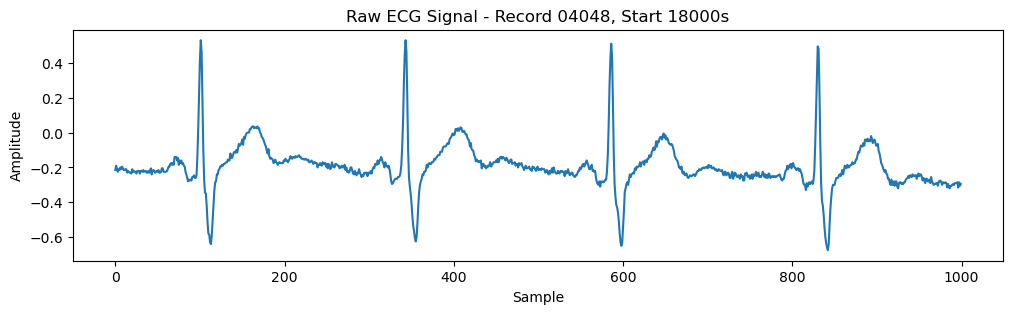

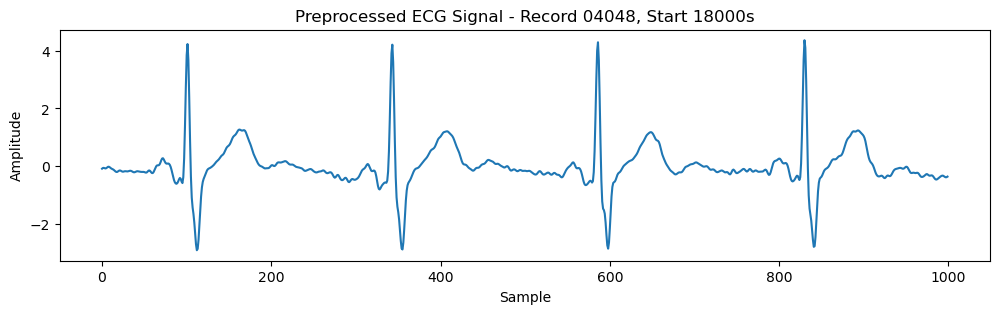

Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=3, Edges=10, Label=0
Graph created: Nodes=2, Edges=2, Label=0
Graph created: Nodes=3, Edges=6, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=18, La

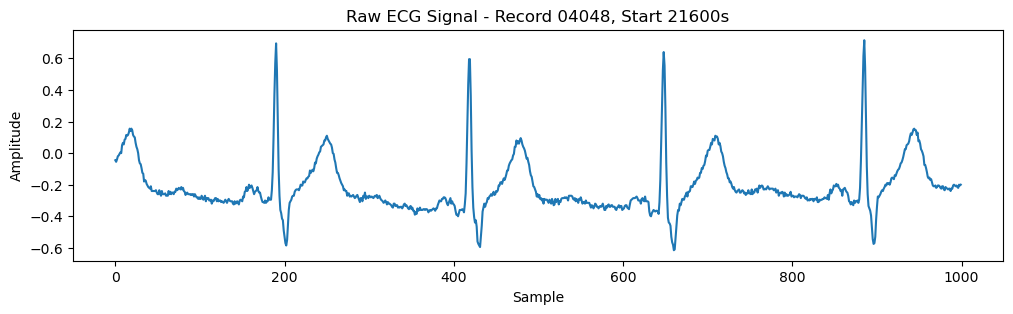

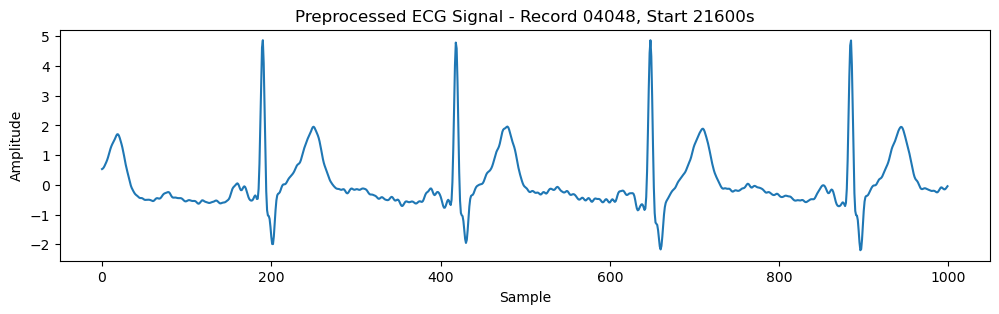

Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=24, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=20, 

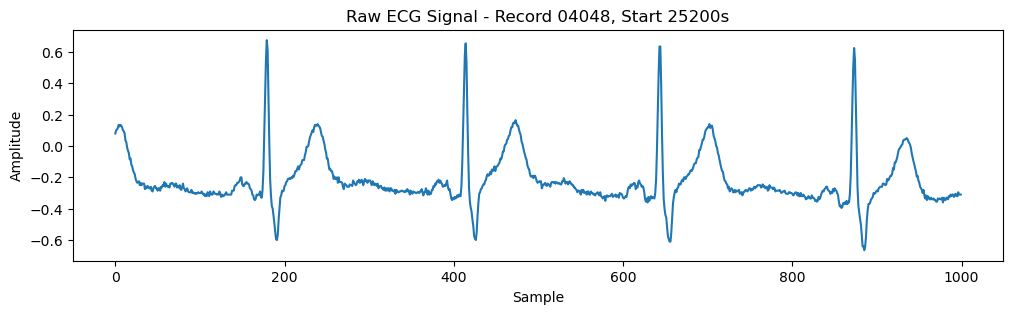

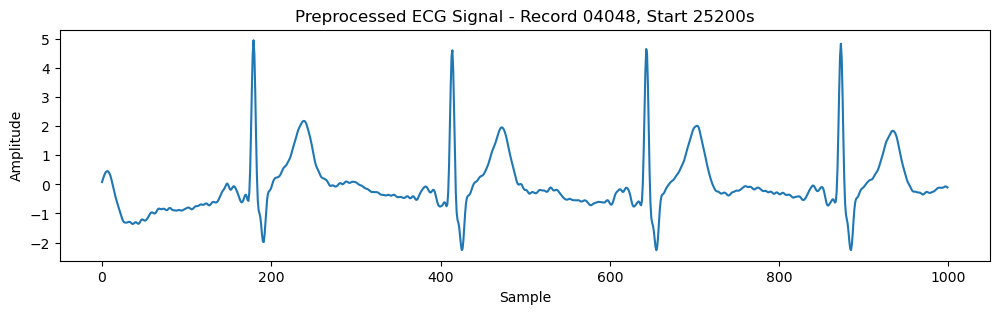

Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, 

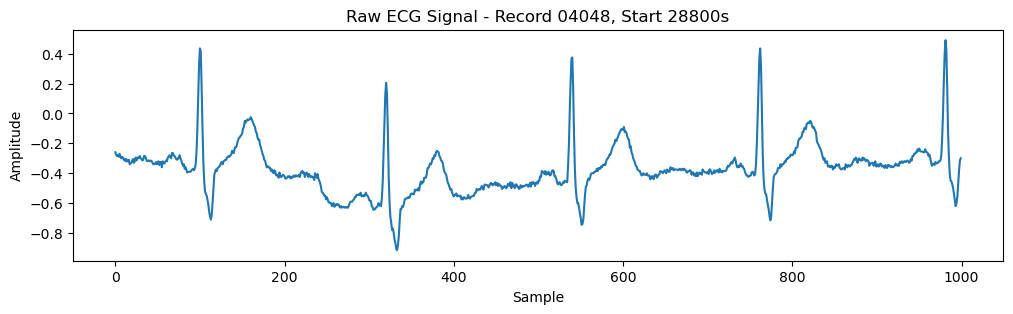

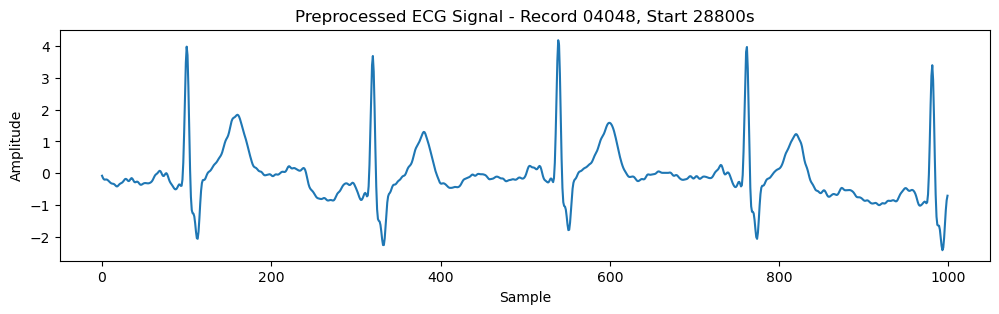

Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=12, Label=0
Graph created: Nodes=5, Edges=14, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=12, Label=0
Graph created: Nodes=4, Edges=8, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, L

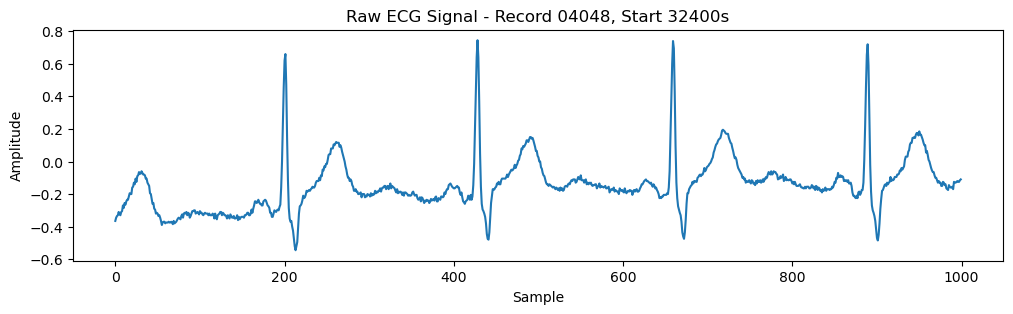

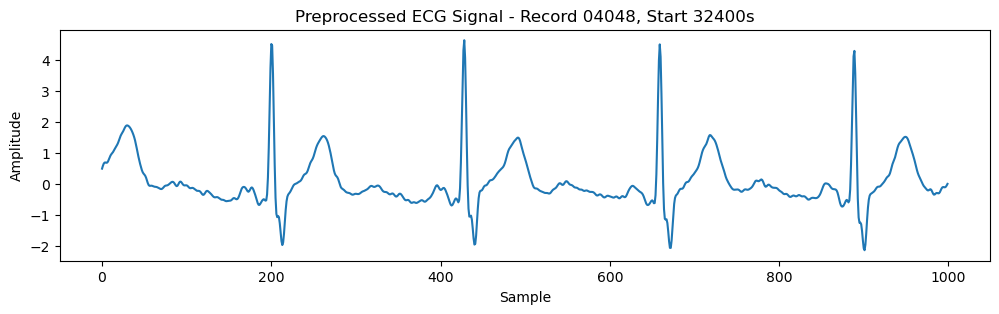

Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=5, Edges=20, Label=0
Graph created: Nodes=5, Edges=28, Label=0
Graph created: Nodes=4, Edges=18, Label=0
Graph created: Nodes=4, Edges=18, 

In [11]:
afdb_records = ['04015', '04043', '04048']
data_dir = 'C://Users//A06BH//Desktop//Aabharan//ELC 2025//mit-bih-atrial-fibrillation-database-1.0.0//files'

all_graphs = process_afdb_dataset(data_dir, afdb_records)
